# Setup environment

In [3]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive  # Import Google Drive mounting utility
    drive.mount('/content/drive')  # Mount Google Drive

    # REPLACE WITH YOUR FOLDER

    base_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data')

    data_folder =  Path('/content')

    !pip install pytorch-lightning==2.0.9 -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq

else:
    # Set base folder path for storing files on local machine
    # REPLACE WITH YOUR FOLDER
    # FILL THIS ONLY IF YOU ARE RUNNING ON A LOCAL MACHINE
    print('Path is /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data')

    base_folder = Path('C:/Users/Vikram/Downloads/BUAN_6382_Applied_DeepLearning-main')
    data_folder = Path('C:/Users/Vikram/Downloads/BUAN_6382_Applied_DeepLearning-main/Custom_files')
    !pip install pytorch-lightning==2.0.9 -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq

Path is /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data


In [4]:
# custom_function_folder = base_folder/'data/custom-functions/fall_2023'
# sys.path.append(str(custom_function_folder))
# model_folder = base_folder/'data/models/dl_fall_2023/dog_breed/oct-9'
# model_folder.mkdir(parents=True, exist_ok=True)
# project_folder = base_folder/'data/imagenette2'
# kaggle_api_folder = base_folder/'data/.kaggle'


# Change the custom_function_folder to folder in your Google drive folder
# Make sure you keep the mlp_skip_two_layer.py and shared_utils.py files
from pathlib import Path
import sys

# Determine the storage location based on the execution environment
# If running on Google Colab, use Google Drive as storage
if 'google.colab' in str(get_ipython()):
    custom_function_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files') # Your Google Drive

    sys.path.append(str(custom_function_folder))
    model_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data') # Google drive folder where you want to save model and logs
    model_folder.mkdir(parents=True, exist_ok=True)
    project_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files')
    kaggle_api_folder = base_folder/'data/.kaggle'

# If running locally, specify a different path
else:
    # Set base folder path for storing files on local machine
    # REPLACE WITH YOUR FOLDER
    # FILL THIS ONLY IF YOU ARE RUNNING ON A LOCAL MACHINE
    print('Path is /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files')
    custom_function_folder = Path('C:/Users/Vikram/Downloads/BUAN_6382_Applied_DeepLearning-main/Custom_files') # Your Google Drive

    sys.path.append(str(custom_function_folder))
    model_folder = Path('C:/Users/Vikram/Downloads/BUAN_6382_Applied_DeepLearning-main/Data') # Google drive folder where you want to save model and logs
    model_folder.mkdir(parents=True, exist_ok=True)
    project_folder = Path('C:/Users/Vikram/Downloads/BUAN_6382_Applied_DeepLearning-main/Custom_files')
    kaggle_api_folder = base_folder/'data/.kaggle'
    # project_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data')


Path is /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files


In [5]:
# import Libraries
import yaml

import torch
import torchmetrics
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc

from data_module_imagenette2 import ImagenetteDataModule
from multiclass_lightning_module_v0 import MultiClassLightningModule
from model_two_layer_bn import TwoLayerMLPBN
from shared_utils import  plot_losses_acc

# Function to load the model

In [6]:
# Function to load the model
def load_model(config):
    model = TwoLayerMLPBN(**config)
    return model

# Functions for Transformations

In [7]:
def get_train_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )

def get_test_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )


# Function to load DataModule

In [8]:
def load_datamodule(config, data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    train_transform = get_train_transforms(**config['train_transform'])
    test_transform = get_test_transforms(**config['test_transform'])
    dm = ImagenetteDataModule(
        data_dir=data_folder,
        train_transform=train_transform,
        test_transform=test_transform,
        **config['data_module']
    )
    return dm

# Function to load LightningModule

In [9]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others']
)
    return lightning_module


# Function to load the Trainer

In [10]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger, wandb_logger],
                            **trainer_config)
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer



# Function to load components

In [11]:
def load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config,
cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model(model_config)

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [12]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

# Function to Load config files

In [13]:
# Load configurations from YAML files
def load_all_configs():
    model_config = load_yaml(project_folder/'model_config.yaml')
    data_module_config = load_yaml(project_folder/'data_module_config.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')

    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config



# Function to free memory

In [14]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

# Run One training and validation batch to check bugs

In [15]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Vikram\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.



  | Name         | Type               | Params
----------------------------------------------------
0 | model        | TwoLayerMLPBN      | 281 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
281 M     Trainable params
0         Non-trainable params
281 M     Total params
1,126.252 Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1/1 [01:11<00:00, 71.06s/it, val_metric=0.156, train_metric=0.000].16 | 

`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 4.93, Train_Metric: 0.00
Epoch 0: 100%|██████████| 1/1 [01:11<00:00, 71.06s/it, val_metric=0.156, train_metric=0.000]


# Find Learning Rate

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Epoch 1: Val_Loss: 4.81, Val_Metric: 0.00 | 

Finding best initial lr: 100%|██████████| 30/30 [00:31<00:00,  1.05s/it]
Learning rate set to 0.006812920690579612
Restoring states from the checkpoint path at c:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\HW\.lr_find_547dd5dc-001f-4ab9-9606-e93b10dcc482.ckpt


Train_Loss: 3.53, Train_Metric: 0.24


Restored all states from the checkpoint at c:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\HW\.lr_find_547dd5dc-001f-4ab9-9606-e93b10dcc482.ckpt


0.006812920690579612


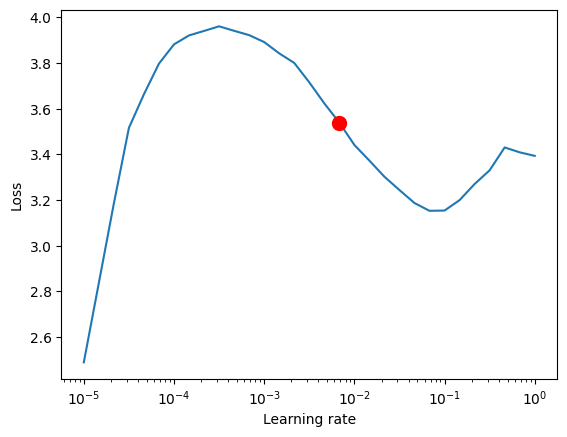

In [16]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs']=5
data_module_config['data_module']['batch_size']=64

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)


# Overfit Small Subset

In [17]:
# Load components

free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size']=128
trainer_config['overfit_batches']=1
lightning_module_config['others']['learning_rate']=0.007
trainer_config['max_epochs']=3
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
trainer.fit(lightning_module, dm)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..

  | Name         | Type               | Params
----------------------------------------------------
0 | model        | TwoLayerMLPBN      | 281 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
281 M     Trainable params
0         Non-trainable params
281 M     Total params
1,126.252 Total estimated model params size (MB)


                                                                           Epoch 1: Val_Loss: 4.81, Val_Metric: 0.00 | 

c:\Users\Vikram\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:262: UserWarning: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
  rank_zero_warn(


Epoch 2: 100%|██████████| 1/1 [01:24<00:00, 84.97s/it, v_num=1, val_metric=0.102, train_metric=0.984] Epoch 3: Val_Loss: 15.44, Val_Metric: 0.10 | Train_Loss: 0.74, Train_Metric: 0.98


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 1/1 [01:31<00:00, 91.32s/it, v_num=1, val_metric=0.102, train_metric=0.984]


# Regularization -I
- Early stopping with a patience of 5, total epochs = 50
- Gradient Clipping
- Weight Deacay of 1
- Reduce Learning rate on plateau
- Use 50% of train/val data

Global seed set to 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Vikram/.netrc


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
c:\Users\Vikram\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name         | Type               | Params
----------------------------------------------------
0 | model        | TwoLayerMLPBN      | 281 M 
1 | loss_fn      | CrossEntropy

Epoch 0: 100%|██████████| 36/36 [02:15<00:00,  3.77s/it, v_num=qb2p, val_metric=0.327, train_metric=0.278]tric: 0.00 | Epoch 1: Val_Loss: 1.91, Val_Metric: 0.33 | Train_Loss: 2.15, Train_Metric: 0.28


Metric val_metric improved. New best score: 0.327


Epoch 1: 100%|██████████| 36/36 [02:22<00:00,  3.97s/it, v_num=qb2p, val_metric=0.385, train_metric=0.379]Epoch 2: Val_Loss: 1.79, Val_Metric: 0.38 | 

Metric val_metric improved by 0.058 >= min_delta = 0.0. New best score: 0.385


Train_Loss: 1.79, Train_Metric: 0.38
Epoch 2: 100%|██████████| 36/36 [02:25<00:00,  4.05s/it, v_num=qb2p, val_metric=0.405, train_metric=0.434]Epoch 3: Val_Loss: 1.77, Val_Metric: 0.41 | 

Metric val_metric improved by 0.020 >= min_delta = 0.0. New best score: 0.405


Train_Loss: 1.63, Train_Metric: 0.43


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 36/36 [02:37<00:00,  4.36s/it, v_num=qb2p, val_metric=0.405, train_metric=0.434]


KeyError: 'train_acc'

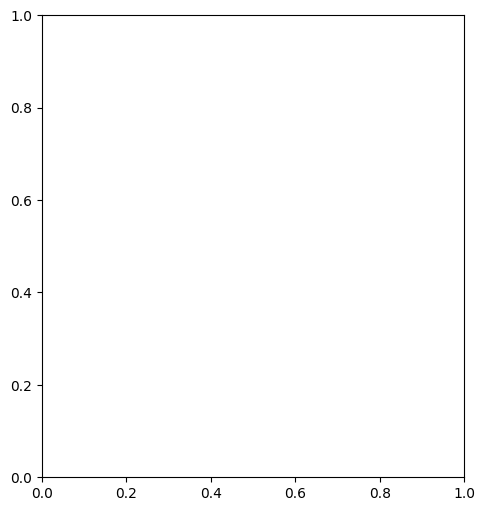

In [18]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size']=128
lightning_module_config['others']['learning_rate']=0.007
trainer_config['max_epochs']=3
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20

lightning_module_config['others']['optimizer_params']['weight_decay']=1
lightning_module_config['others']['learning_rate']=0.007
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.ReduceLROnPlateau'
lightning_module_config['scheduler_params']= {'mode': 'max', 'patience': 0, 'factor': 0.5, 'verbose': True}
lightning_module_config['scheduler_options']= {'monitor': 'val_metric', 'interval': 'epoch', 'frequency': 1}
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='imagenette2_multiclass'
cl_config['wandb']['name']='two_layer_mlp_bn_v0'

data_module_config['data_module']['small_subset']=True
data_module_config['data_module']['num_samples_small']=0.5

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)
dm.setup()
trainer.fit(lightning_module, dm)

In [23]:
file = f"{trainer.logger.log_dir}\\metrics.csv"
file
# plot_losses_acc(file)

'C:\\Users\\Vikram\\Downloads\\BUAN_6382_Applied_DeepLearning-main\\Data\\logs\\csvlogger\\version_12\\metrics.csv'

In [24]:
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

Restoring states from the checkpoint path at C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\epoch=2-step=108.ckpt
Loaded model weights from the checkpoint at C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\epoch=2-step=108.ckpt
c:\Users\Vikram\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation DataLoader 0: 100%|██████████| 36/36 [00:09<00:00,  3.78it/s]Epoch 4: Val_Loss: 1.52, Val_Metric: 0.50 | 


Restoring states from the checkpoint path at C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\epoch=2-step=108.ckpt
Loaded model weights from the checkpoint at C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\epoch=2-step=108.ckpt


Validation DataLoader 0: 100%|██████████| 8/8 [00:01<00:00,  4.93it/s]Epoch 4: Val_Loss: 1.77, Val_Metric: 0.41 | 
Train Accuracy: 49.65
Validation Accuracy: 40.53


epoch,▁▁▁▃▃▃▃▆▆▆▆██
lr-AdamW,▁▁▁
train_loss_epoch,█▃▁
train_loss_step,█▆▅▁▁
train_metric,▁▆█
trainer/global_step,▁▂▃▃▃▄▅▆▆▆▆▇████
val_loss,█▆▆▁▆
val_metric,▁▃▄█▄
epoch,3
lr-AdamW,0.007
train_loss_epoch,1.63349


# Regularization -II
- Increase the weight decay to 10

In [25]:
lightning_module_config

{'optimizer_cls': 'torch.optim.AdamW',
 'loss_fn': 'torch.nn.CrossEntropyLoss',
 'metric_cls': 'torchmetrics.Accuracy',
 'scheduler_cls': 'torch.optim.lr_scheduler.ReduceLROnPlateau',
 'scheduler_options': {'monitor': 'val_metric',
  'interval': 'epoch',
  'frequency': 1},
 'scheduler_params': {'mode': 'max',
  'patience': 0,
  'factor': 0.5,
  'verbose': True},
 'others': {'optimizer_params': {'weight_decay': 1},
  'num_classes': 120,
  'learning_rate': 0.007,
  'log_every_n_steps': 1,
  'log_test_metrics': True,
  'display_metrics': True}}

In [26]:
lightning_module_config['others']['optimizer_params']['weight_decay']=10

In [27]:
lightning_module_config

{'optimizer_cls': 'torch.optim.AdamW',
 'loss_fn': 'torch.nn.CrossEntropyLoss',
 'metric_cls': 'torchmetrics.Accuracy',
 'scheduler_cls': 'torch.optim.lr_scheduler.ReduceLROnPlateau',
 'scheduler_options': {'monitor': 'val_metric',
  'interval': 'epoch',
  'frequency': 1},
 'scheduler_params': {'mode': 'max',
  'patience': 0,
  'factor': 0.5,
  'verbose': True},
 'others': {'optimizer_params': {'weight_decay': 10},
  'num_classes': 120,
  'learning_rate': 0.007,
  'log_every_n_steps': 1,
  'log_test_metrics': True,
  'display_metrics': True}}

In [28]:
# Regularization -II
free_memory()
seed_everything(42)

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)
dm.setup()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
print(file)
# plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")

Global seed set to 42
wandb: Currently logged in as: harikrish0607 (harikrishnad). Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
c:\Users\Vikram\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name         | Type               | Params
----------------------------------------------------
0 | model        | TwoLayerMLPBN      | 281 M 
1 | loss_fn      | CrossEntropy

Epoch 0: 100%|██████████| 36/36 [02:06<00:00,  3.51s/it, v_num=ccsj, val_metric=0.107, train_metric=0.272]tric: 0.00 | Epoch 1: Val_Loss: 2.36, Val_Metric: 0.11 | 

Metric val_metric improved. New best score: 0.107


Train_Loss: 2.25, Train_Metric: 0.27
Epoch 1: 100%|██████████| 36/36 [02:26<00:00,  4.08s/it, v_num=ccsj, val_metric=0.309, train_metric=0.343]Epoch 2: Val_Loss: 2.28, Val_Metric: 0.31 | 

Metric val_metric improved by 0.202 >= min_delta = 0.0. New best score: 0.309


Train_Loss: 2.07, Train_Metric: 0.34
Epoch 2: 100%|██████████| 36/36 [02:20<00:00,  3.90s/it, v_num=ccsj, val_metric=0.318, train_metric=0.350]Epoch 3: Val_Loss: 2.13, Val_Metric: 0.32 | 

Metric val_metric improved by 0.009 >= min_delta = 0.0. New best score: 0.318


Train_Loss: 2.04, Train_Metric: 0.35


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 36/36 [02:31<00:00,  4.21s/it, v_num=ccsj, val_metric=0.318, train_metric=0.350]
C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\csvlogger\version_13/metrics.csv


Restoring states from the checkpoint path at C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\epoch=2-step=108-v1.ckpt
Loaded model weights from the checkpoint at C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\epoch=2-step=108-v1.ckpt
c:\Users\Vikram\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation DataLoader 0: 100%|██████████| 36/36 [00:09<00:00,  3.84it/s]Epoch 4: Val_Loss: 2.06, Val_Metric: 0.37 | 


Restoring states from the checkpoint path at C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\epoch=2-step=108-v1.ckpt
Loaded model weights from the checkpoint at C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\epoch=2-step=108-v1.ckpt


Validation DataLoader 0: 100%|██████████| 8/8 [00:01<00:00,  4.72it/s]Epoch 4: Val_Loss: 2.13, Val_Metric: 0.32 | 
Train Accuracy: 36.65
Validation Accuracy: 31.77


In [29]:
wandb.finish()

epoch,▁▁▁▃▃▃▃▆▆▆▆██
lr-AdamW,▁▁▁
train_loss_epoch,█▂▁
train_loss_step,█▆▅▁▁
train_metric,▁▇█
trainer/global_step,▁▂▃▃▃▄▅▆▆▆▆▇████
val_loss,█▆▃▁▃
val_metric,▁▆▇█▇
epoch,3
lr-AdamW,0.007
train_loss_epoch,2.04487


# HW5 PART A - Complete Regularization -III and IV

# Regularization -III
- Use one Cycle Learning Rate instead of Reduce Learning Rate on Plateau

In [30]:
free_memory()
seed_everything(42)
import numpy as np


model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size']=128
lightning_module_config['others']['learning_rate']=0.007
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20
trainer_config['max_epochs']=10

lightning_module_config['others']['optimizer_params']['weight_decay']=10


# Setting the scheduler class
lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

# Parameters for the OneCycleLR
# Note: 'max_lr' is a required parameter for OneCycleLR; you'll need to specify it based on your needs
lightning_module_config['scheduler_params'] = {'max_lr':1e-3,'steps_per_epoch':8, 'final_div_factor': 1e4, 'div_factor': 25.0, 'pct_start':0.3, 'anneal_strategy':'cos','epochs':4}

# Options related to the monitoring of the scheduler (if needed)
lightning_module_config['scheduler_options'] = {'monitor': 'val_metric', 'interval': 'epoch', 'frequency': 1}



model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=False) # change here
dm.prepare_data()

trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
# plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

Global seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
c:\Users\Vikram\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\Vikram\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\core\optimizer.py:289: RuntimeWarning: A `OneCycleLR` scheduler is using 'interval': 'e

Epoch 9: 100%|██████████| 73/73 [03:30<00:00,  2.89s/it, v_num=cw92, val_metric=0.428, train_metric=0.514]Epoch 10: Val_Loss: 1.99, Val_Metric: 0.43 | Train_Loss: 1.83, Train_Metric: 0.51


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 73/73 [03:36<00:00,  2.96s/it, v_num=cw92, val_metric=0.428, train_metric=0.514]


Restoring states from the checkpoint path at C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\epoch=2-step=219.ckpt
Loaded model weights from the checkpoint at C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\epoch=2-step=219.ckpt
c:\Users\Vikram\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation DataLoader 0: 100%|██████████| 73/73 [00:20<00:00,  3.58it/s]Epoch 11: Val_Loss: 1.45, Val_Metric: 0.60 | 


Restoring states from the checkpoint path at C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\epoch=2-step=219.ckpt
Loaded model weights from the checkpoint at C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\epoch=2-step=219.ckpt


Validation DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.85it/s]Epoch 11: Val_Loss: 1.80, Val_Metric: 0.45 | 
Train Accuracy: 59.52
Validation Accuracy: 44.73


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
lr-AdamW,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▇▇▇▇▇▇▇▇███████
train_loss_epoch,█▄▂▁▁▁▂▂▂▂
train_loss_step,█▇▇▆▄▄▃▂▂▂▁▁▁▁▁▁▂▂▁▂▂▁▂▂▂▂▂▂▂▂▂▃▂▂▃▂
train_metric,▁▄▆████▇▇▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
val_loss,█▄▃▃▃▄▃▃▄▄▁▃
val_metric,▁▂▃▂▂▂▂▂▁▂█▃
epoch,10
lr-AdamW,0.001
train_loss_epoch,1.82871


# Regularization-1V
- Use one Step LR instead of One Cycler LR

In [31]:
free_memory()
seed_everything(42)

model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size']=128
lightning_module_config['others']['learning_rate']=0.007
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20
trainer_config['max_epochs']=5

lightning_module_config['others']['optimizer_params']['weight_decay']=10


# Setting the scheduler class
lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.StepLR' # CODE HERE

# Parameters for the OneCycleLR
# Note: 'max_lr' is a required parameter for OneCycleLR; you'll need to specify it based on your needs
lightning_module_config['scheduler_params'] = {'step_size':10, 'gamma': 0.5}

# Options related to the monitoring of the scheduler (if needed)
lightning_module_config['scheduler_options'] = {'monitor': 'val_metric', 'interval': 'epoch', 'frequency': 1}



model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=False) # change here
dm.prepare_data()

trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
# plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

Global seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
c:\Users\Vikram\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name         | Type               | Params
----------------------------------------------------
0 | model        | TwoLayerMLPBN      | 281 M 
1 | loss_fn      | CrossEntropy

Epoch 4: 100%|██████████| 73/73 [04:38<00:00,  3.82s/it, v_num=nqp2, val_metric=0.330, train_metric=0.350]  Epoch 5: Val_Loss: 2.03, Val_Metric: 0.33 | Train_Loss: 2.02, Train_Metric: 0.35


`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 73/73 [04:44<00:00,  3.89s/it, v_num=nqp2, val_metric=0.330, train_metric=0.350]


Restoring states from the checkpoint path at C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\epoch=3-step=292.ckpt
Loaded model weights from the checkpoint at C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\epoch=3-step=292.ckpt
c:\Users\Vikram\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation DataLoader 0: 100%|██████████| 73/73 [00:20<00:00,  3.63it/s]Epoch 6: Val_Loss: 2.01, Val_Metric: 0.36 | 


Restoring states from the checkpoint path at C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\epoch=3-step=292.ckpt
Loaded model weights from the checkpoint at C:\Users\Vikram\Downloads\BUAN_6382_Applied_DeepLearning-main\Data\logs\epoch=3-step=292.ckpt


Validation DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.66it/s]Epoch 6: Val_Loss: 2.07, Val_Metric: 0.33 | 
Train Accuracy: 36.17
Validation Accuracy: 33.01


epoch,▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇██
lr-AdamW,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▃▂▁▁
train_loss_step,█▅█▇▄▆▅▁▄▆▂▁▁▄▄█▄▂
train_metric,▁▆▆▇█
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
val_loss,█▃▃▂▁▁▂
val_metric,▁▃▄▅▅█▅
epoch,5
lr-AdamW,0.007
train_loss_epoch,2.02128
